<a href="https://colab.research.google.com/github/CsonVass/raman/blob/main/DissolutionFromRaman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

# <strong>Előkészítés</strong>
</div>


<div class="markdown-google-sans">

## <strong>Szükséges könyvátrak importálása</strong>
</div>


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import tensorflow as tf
from keras import layers
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from tensorflow.python.ops.nn_ops import softmax
from timeit import default_timer as timer

<div class="markdown-google-sans">

## <strong>Raman térképek és kioldódási görbék importálása Google Drive tárhelyről</strong>
</div>

* <u>map_curve_pairs</u>: Szótár a Raman térképek és kioldódási görbék párosításához 
* <u>missing</u>: Esetleges hiányzó/rossz formátumban lévő adatokat helyezzük ebbe a tömbbe. Ezek az adatok nem kerülnek felhasználásra egyáltalán (jelenleg nem kerül ide semmi)

In [ ]:
DRIVE_PATH = 'drive/MyDrive/Colab Notebooks/DissolutionFromRaman/'

In [ ]:
map_curve_pairs = {}
missing = []
path_to_hpmc =  DRIVE_PATH + 'Raman/maps'

dir_list = os.listdir(path_to_hpmc)
for f in dir_list: 
  path_to_map = path_to_hpmc + '/' + f
  map_name = f.split('-')[0].split('_')[1]
  map_curve_pairs[map_name] = {}
  map_csv = pd.read_csv(path_to_map, header=None)
  if len(map_csv.index) == 1:
    tmp = []
    for i in range(0, 31*31, 31):
      tmp.append([map_csv.iloc[0:1, i:i+31].values])
    map_csv = pd.DataFrame(tmp)
  map_curve_pairs[map_name]['map'] = tf.reshape(tf.convert_to_tensor(map_csv, tf.float32), [31, 31])

dissolutionCureves = []
curves_csv = pd.read_csv(DRIVE_PATH + 'Raman/Tablettak_minden_adat.csv', header=None)
names = curves_csv.iloc[0:1, 1:]
time = curves_csv.iloc[4:,0:1]
curve_points = curves_csv.iloc[4:,1:].apply(lambda x: x.str.replace(',','.'))
for i in range(len(curve_points.columns)):
    curve_i = curve_points.iloc[:, i:i+1]
    if(names.iloc[0,i] in map_curve_pairs):
      map_curve_pairs[names.iloc[0,i]]['curve'] = tf.reshape(tf.convert_to_tensor(curve_i, tf.float32), [1, 37])
    else: 
      missing.append(names.iloc[0,i])

mcp_cpy = map_curve_pairs.copy()
for name in mcp_cpy:
  if not 'curve' in map_curve_pairs[name] or len(map_curve_pairs[name]['map']) != 31:
    missing.append(map_curve_pairs[name])
    map_curve_pairs.pop(name)

<div class="markdown-google-sans">

## <strong>Beolvasott adatok felbontása tanító és ellenőrző halmazokra</strong>
</div>

A görbe értékek normalizálása 0-100 intervallumról 0-1 intervallumra

In [ ]:
map_values_orig = []
curve_values_orig = []

for key in sorted(map_curve_pairs):
 map_values_orig.append(map_curve_pairs[key]['map'])
 curve_values_orig.append(map_curve_pairs[key]['curve'])

<div class="markdown-google-sans">

## <strong>Augmentáció</strong>
</div>

Az adathalmaz kibővítése

Nincs augmentáció

In [ ]:
is_augmented = False
is_train_augmented = False

Teljes adathalmaz augmentálása

In [ ]:
is_augmented = True
is_train_augmented = False

Csak teszt adathalmaz augmentálása

In [ ]:
is_train_augmented = True
is_augmented = False

In [ ]:
map_values = [x_ for x_ in map_values_orig]

# Kioldódási görbe értékek 0-100 intervallumra skálázása
curve_values = [((y_) * (100)) / np.max(y_) for y_ in curve_values_orig]

# Kioldódási görbe értékek normalizálása
curve_values = [y_ / 100 for y_ in curve_values_orig]

if is_augmented: 
  x_aug = []
  y_aug = []
  for i in range(len(map_values)):
    x_aug.append(np.rot90(map_values[i], k=1))
    y_aug.append(curve_values[i])

    x_aug.append(np.rot90(map_values[i], k=2))
    y_aug.append(curve_values[i])

    x_aug.append(np.rot90(map_values[i], k=3))
    y_aug.append(curve_values[i])
  
  map_values = np.concatenate((map_values, x_aug))
  curve_values = np.concatenate((curve_values, y_aug))


x_train, x_test, y_train, y_test = train_test_split(map_values, curve_values, random_state=42)

x_train = np.array(x_train)
y_train = np.array(y_train)

test_len = len(curve_values) - len(y_train)

if is_train_augmented:
  x_aug = []
  y_aug = []
  for i in range(len(x_train)):
    x_aug.append(np.rot90(x_train[i], k=1))
    y_aug.append(y[i])

    x_aug.append(np.rot90(x_train[i], k=2))
    y_aug.append(y[i])

    x_aug.append(np.rot90(x_train[i], k=3))
    y_aug.append(y[i])
  
  x_train = np.concatenate((x_train, x_aug))
  y_train = np.concatenate((y_train, y_aug))


y_train = y_train.reshape((len(y_train), 37))

x_test = np.array(x_test)
y_test = np.array(y_test)

y_test = y_test.reshape(test_len, 37)

y_test100 = [y_ * 100 for y_ in y_test]

<div class="markdown-google-sans">

# <strong>Neurális hálók</strong>
</div>

A hálók felépítéséhez a Sequential API-t használjuk, amely intuitívabb a Funtional API-nál, viszont kevésbé testreszabható.
A hálók bemenetei réteg neuronjai a Raman térképek 31x31 pixelei, a kimentei layer a kioldódási görbe pontjai.

A hálókat lehet importálni Google Drive-ról, létrehozni újakat és menteni őket szintén Google Drive-ra.

<div class="markdown-google-sans">

## <strong>Kiértékelést segítő függvények</strong>
</div>

* <u>model_loss_value</u>: Visszaadja a model loss értékét
* <u>accuracy_for_one</u>: Visszaadja egy test-re vett pontosságát a modellnek
* <u>accuracy_for_all</u>: Visszaadja a test-esetek átlagot pontosságát
* <u>visualize_results</u>: Kirajzolja egymásra az elvárt (kék) és számított (piros) eredményeket 

In [ ]:
def model_loss_value(model, x_, y_):
  score = model.evaluate(x_, y_, verbose=0)
  return score

def accuracy_for_one(test_, pre_):
  s = 0
  for i in range(len(pre_)):
    s = s + (test_[i] - pre_[i]) ** 2
   
  f2 = 50 * math.log(((1 + 1/len(pre_) * s) ** -0.5)*100,10)
  return f2

def accuracy_for_all(test_, pre_):
  accuracies = []
  for i in range(len(pre_)):
    accuracies.append(accuracy_for_one(test_[i], pre_[i]))
  
  avg = np.average(accuracies)
  max = np.max(accuracies)
  min = np.min(accuracies)
  std = np.std(accuracies)
  variance = np.var(accuracies)
  valid_rate = len([i for i in accuracies if i >= 50]) / len(accuracies) * 100

  return {"avg": avg, 
          "max": max,
          "min": min,
          "std": std,
          "variance": variance,
          "valid_rate": valid_rate,
          "all": accuracies}

def visualize_results(time_, test_, pre_):
  x1 = np.array(time_).flatten()
  for t in range(len(test_)):  
    y1 = test_[t]
    if t % 2 == 0:
      plt.figure()
    ax = plt.subplot(1, 2, t%2+1)

    plt.tick_params(  
      which='both',      
      bottom=True,      
      top=False,         
      left = True,
      right = False,
      labelbottom=True,
      labelleft=True,
      labelsize=5)
    
    plt.title('Pontosság')
    plt.ylabel('Kioldódás (%)')
    plt.xlabel('Idő (perc)')
    plt.plot(x1, y1)
    plt.plot(x1, pre_[t], color="red")
    plt.legend(['measureed', 'predicted'], loc='lower right')
    plt.grid()
    plt.xticks(x1[0::5])
    textstr = '\n'.join((
      r'$\mathrm{f_2}=%.2f$' % (accuracy_for_one(y1, pre_[t]), )))

    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # ax.text(, 0.95, textstr, transform=ax.transAxes, fontsize=5,
    #     verticalalignment='top')
        

def save_results_graph(time_, test_, pre_, fileName):
  pp = PdfPages(DRIVE_PATH + "saved_model/" + fileName + "/results.pdf") 
  x1 = np.array(time_).flatten()
  for t in range(len(test_)):  
    y1 = test_[t]
    if t % 2 == 0:
      plt.figure()
    plt.subplot(1, 2, t%2+1)

    plt.tick_params(  
      which='both',      
      bottom=True,      
      top=False,         
      left = True,
      right = False,
      labelbottom=True,
      labelleft=True,
      labelsize=5)
        
    plt.title('Pontosság')
    plt.ylabel('Kioldódás (%)')
    plt.xlabel('Idő (perc)')
    plt.plot(x1, y1)
    plt.plot(x1, pre_[t], color="red")
    plt.legend(['measureed', 'predicted'], loc='lower right')
    plt.grid()
    plt.xticks(x1[0::5])
    if t % 2 == 1:
      plt.savefig(pp, format='pdf')
  pp.close()

def save_dissolution_graph(time_, dis_):
  pp = PdfPages(DRIVE_PATH + "figures/dissolution.pdf") 
  t = np.array(time_).flatten()
  plt.tick_params(  
      which='both',      
      bottom=True,      
      top=False,         
      left = True,
      right = False,
      labelbottom=True,
      labelleft=True,
      labelsize=5)
  plt.title('Kioldódási görbe')
  plt.ylabel('Kioldódás (%)')
  plt.xlabel('Idő (perc)')
  plt.plot(t, dis_ * 100)
  plt.grid()
  plt.xticks(t[0::5])
  plt.savefig(pp, format='pdf')
  pp.close()

def visualize_loss(history):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Modell hiba')
  plt.ylabel('Hiba')
  plt.xlabel('Tanítási ciklus')
  plt.legend(['train', 'test'], loc='upper right')
  plt.grid()

def save_loss_graph(history, fileName):
  pp = PdfPages(DRIVE_PATH + "saved_model/" + fileName + "/loss.pdf") 
  visualize_loss(history)
  plt.savefig(pp, format='pdf')
  pp.close()


class TraininTimeCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)  

<div class="markdown-google-sans">

## <strong>Modell beállítása</strong>
</div>


<div class="markdown-google-sans">

### <strong>Importálás Google Drive tárhelyről</strong>
</div>

In [ ]:
model_name = input('Enter a name for the model: ')
path_to_model = DRIVE_PATH + 'saved_model/' + model_name + '/model'
model = tf.keras.models.load_model(path_to_model)

with open(DRIVE_PATH + 'saved_model/' + model_name + '/history', "rb") as file_pi:
    losses_history = pickle.load(file_pi)

Enter a name for the model: cnn1


<div class="markdown-google-sans">

### <strong>Felépítése</strong>
</div>

<div class="markdown-google-sans">

#### <strong>CNN 1</strong>
</div>

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(input_shape=(31, 31, 1), filters=64, kernel_size=(3, 3), activation="relu"))
model.add(layers.Conv2D(input_shape=(27, 27, 1), filters=64, kernel_size=(3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(37, activation="relu"))

model.compile(optimizer="adam",
              loss="mean_squared_logarithmic_error", 
               metrics=[])

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(input_shape=(31, 31, 1), filters=64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPool2D((2,2), strides=(2,2)))
model.add(layers.Conv2D(input_shape=(14, 14, 1), filters=64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPool2D((2,2), strides=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(37, activation="relu"))

model.compile(optimizer="adam",
              loss="mean_squared_logarithmic_error", 
               metrics=[])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2304)             

<div class="markdown-google-sans">

#### <strong>Dense</strong>
</div>

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(37, activation="relu"))

model.compile(optimizer="adam",
              loss="mean_squared_logarithmic_error", 
               metrics=[])

<div class="markdown-google-sans">

#### <strong>CNN 2</strong>
</div>

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(input_shape=(31, 31, 1), filters=64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(37, activation="relu"))

model.compile(optimizer="adam",
              loss="mean_squared_logarithmic_error", 
               metrics=[])


<div class="markdown-google-sans">

## <strong>Általános modell generáló függvény</strong>
</div>


In [ ]:
class ConvDetails:
  def __init__(self, input_shape, number_of_filters, kernel_size, activation, pool_type, pool_size, strides):
    self.input_shape = input_shape
    self.number_of_filters = number_of_filters
    self.kernel_size = kernel_size
    self.activation = activation
    self.pool_type = pool_type
    self.pool_size = pool_size
    self.strides = strides

class AugmentationDetails:
  def __init__(self, flip, rotation):
    self.flip = flip
    self.rotation = rotation

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

def generateNetwork(convDetailsList, augmentationDetails, validation_split, epochs):
  model_ = tf.keras.models.Sequential()
  if augmentationDetails is not None: 
    if augmentationDetails.flip is not False:
      model_.add(layers.RandomFlip("horizontal_and_vertical", input_shape=(31, 31, 1)))
    if augmentationDetails.rotation is not None:
      model_.add(layers.RandomRotation(augmentationDetails.rotation, input_shape=(31, 31, 1)))
    
  for convDetails in convDetailsList:
    model_.add(layers.Conv2D(input_shape=convDetails.input_shape, filters=convDetails.number_of_filters, kernel_size=convDetails.kernel_size, activation=convDetails.activation))
    if convDetails.pool_type == "max":
      model_.add(layers.MaxPool2D(convDetails.pool_size, strides=convDetails.strides))
    else:
      model_.add(layers.AveragePooling2D(convDetails.pool_size, strides=convDetails.strides))
  model_.add(layers.Flatten())
  model_.add(layers.Dropout(0.5))
  model_.add(layers.Dense(37, activation="relu"))

  model_.compile(optimizer="adam",
                loss="mean_squared_logarithmic_error", 
                metrics=[])

  model_.fit(x_train, y_train, validation_split=validation_split, epochs=epochs, batch_size=10,
          verbose=0)
  
  pre_ = model_.predict(x_test)
  pre100_ = [p * 100 for p in pre_]
  ac_ = accuracy_for_all(y_test100, pre100_)
  return {ac_: model_} 


In [ ]:
cdetails1 = ConvDetails(input_shape=(31, 31, 1), number_of_filters=64, kernel_size=(3,3), activation="relu", pool_type="max", pool_size=(2,2), strides=(2,2))
cdetails2 = ConvDetails(input_shape=(31, 31, 1), number_of_filters=64, kernel_size=(3,3), activation="relu", pool_type="max", pool_size=(2,2), strides=(2,2))



res = generateNetwork([cdetails1, cdetails2], None, validation_split=0.33, epochs=100)

print(res)

2/2 [==============================] - 0s 41ms/step
{50.597581485767726: <keras.engine.sequential.Sequential object at 0x7ff4801a9d90>}


<div class="markdown-google-sans">

## <strong>Tanítás</strong>
</div>

<div class="markdown-google-sans">

### <strong>Modell tanítása</strong>
</div>


In [ ]:
cb = TraininTimeCallback()
history = model.fit(x_train, y_train, validation_split=0.33, batch_size=100, epochs=100, callbacks=[cb],
          verbose=0)

losses_history = history.history

Train with early stopping

In [ ]:
es_cb = EarlyStopping(monitor='val_loss', patience=20)
cb = TraininTimeCallback()
history = model.fit(x_train, y_train, validation_split=0.33, batch_size=10, epochs=100, callbacks=[cb, es_cb],
          verbose=0)

losses_history = history.history


<div class="markdown-google-sans">

### <strong>Modell mentése Google Drive tárhelyre</strong>
</div>


In [ ]:
model_name = input('Enter a name for the model: ')
path_to_model = DRIVE_PATH + 'saved_model/' + model_name + '/model'
model.save(path_to_model) 

Enter a name for the model: cnn2


<div class="markdown-google-sans">

## <strong>Értékelés</strong>
</div>


<div class="markdown-google-sans">

### <strong>Tanítás összideje</strong>
</div>

In [ ]:
train_time = sum(cb.logs)
print(train_time)

<div class="markdown-google-sans">

### <strong>Háló loss értékének kiszámítása a teszt adatok segítéségvel</strong>
</div>

In [ ]:
train_loss = model_loss_value(model, x_train, y_train) 
test_loss = model_loss_value(model, x_test, y_test)

print("Train loss: {0}".format(train_loss))
print("Test loss: {0}".format(test_loss))

Train loss: 0.005075093824416399
Test loss: 0.009740241803228855


<div class="markdown-google-sans">

### <strong>Model eredményeinek visszaállítása 0-100 intervallumra </strong>
</div>

In [ ]:
pre = model.predict(x_test)
pre100 = [p * 100 for p in pre]

2/2 [==============================] - 0s 4ms/step


<div class="markdown-google-sans">

### <strong>Tanítási és tesztelési loss értékek vizualizációja</strong>
</div>


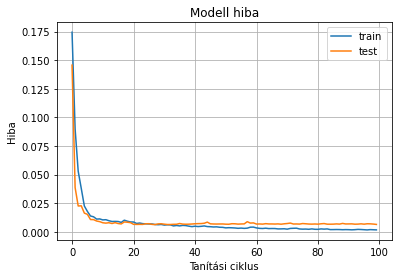

In [ ]:
visualize_loss(losses_history)

<div class="markdown-google-sans">

### <strong>Kioldódási görbék vizualizációja</strong>
</div>


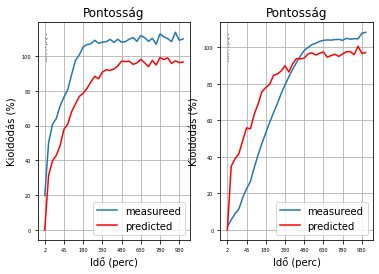

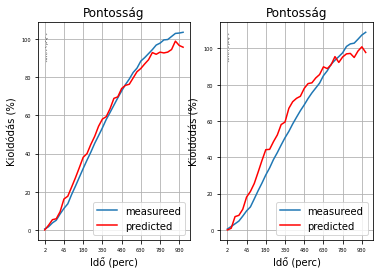

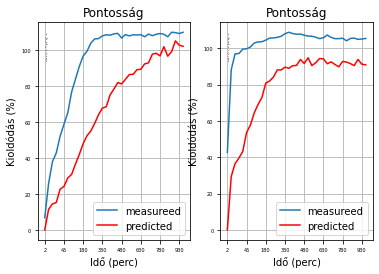

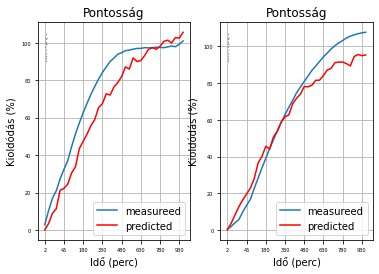

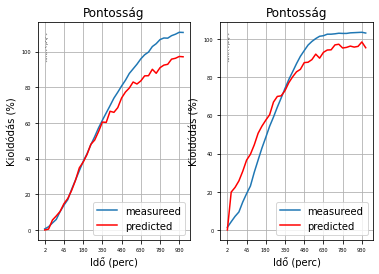

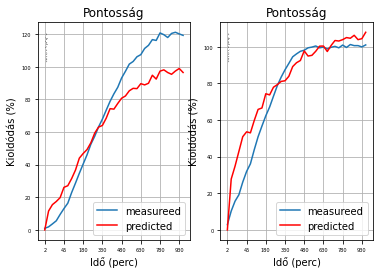

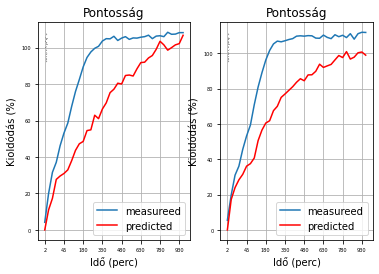

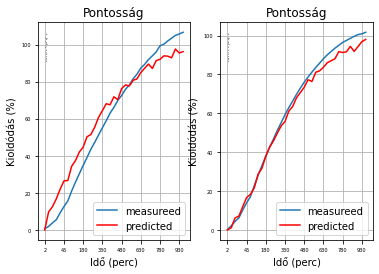

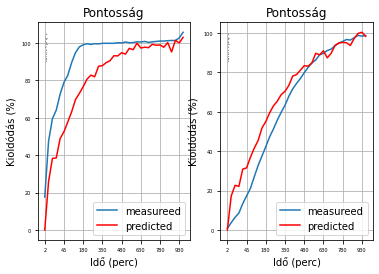

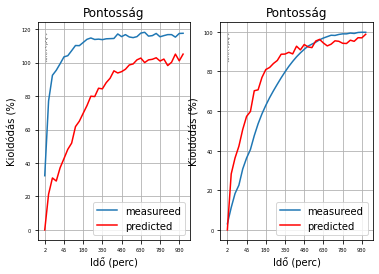

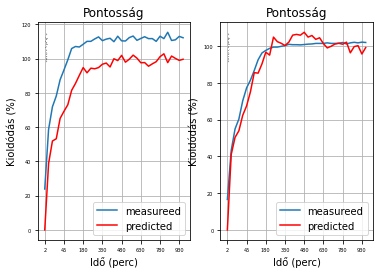

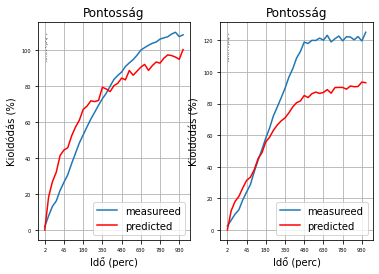

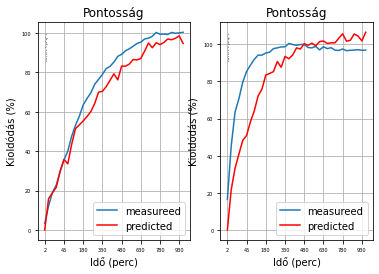

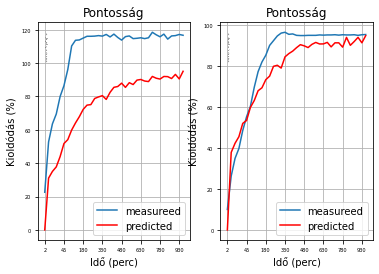

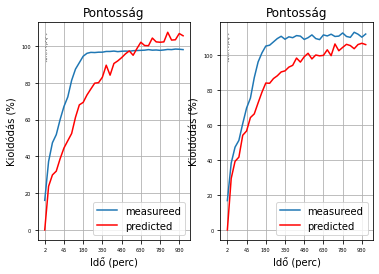

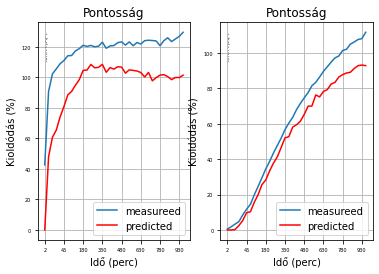

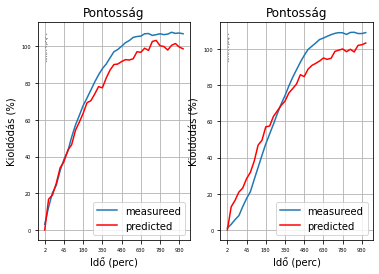

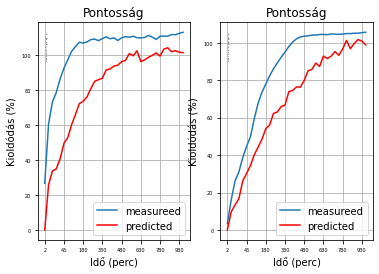

In [ ]:
visualize_results(time, y_test100, pre100)

<div class="markdown-google-sans">

### <strong>Pontosság kiszámítása</strong>
</div>


In [ ]:
results = accuracy_for_all(y_test100, pre100)
for k in results.keys():
  print("{0}: {1}".format(k, results[k]))

print(sum(cb.logs))

avg: 44.835608287451095
max: 66.41420558189198
min: 28.6589187940568
std: 11.08271150986013
variance: 122.82649441078622
valid_rate: 27.77777777777778
all: [55.80089054753303, 30.685050948247977, 50.20454482868342, 46.7041486173687, 35.230738908900975, 31.704548340888785, 59.79236462585092, 50.76080498386274, 43.6957807637957, 34.99992601710952, 36.04712324755632, 59.926973014919795, 31.847902557811818, 33.307531508139924, 55.99613974906761, 63.56510742597463, 47.77446269133543, 46.68333440628214, 28.6589187940568, 49.917943904178664, 44.70160091965688, 47.21079446637814, 62.96396071640401, 31.04174913274212, 66.20783510153016, 36.682381915350454, 30.610926901937844, 48.871569950307794, 43.238152784580265, 41.77629887946152, 30.77839223515116, 46.37310488322584, 66.41420558189198, 38.138288125340985, 36.9885463980276, 48.77985447468759]
3.023212950996367


<div class="markdown-google-sans">

## <strong>Statisztikák mentése</strong>
</div>


<div class="markdown-google-sans">

### <strong>Görbék</strong>
</div>


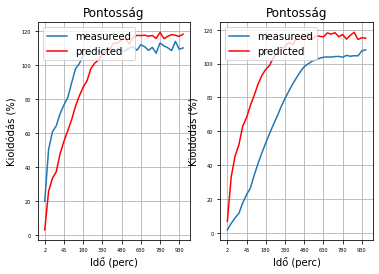

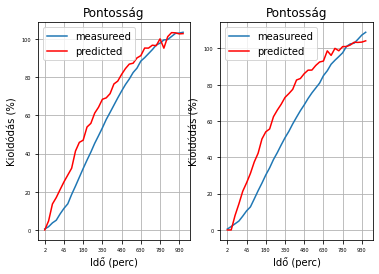

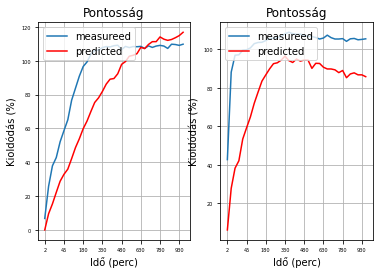

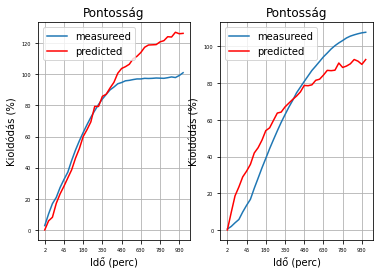

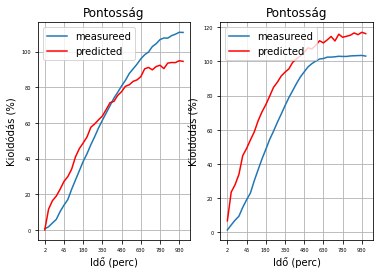

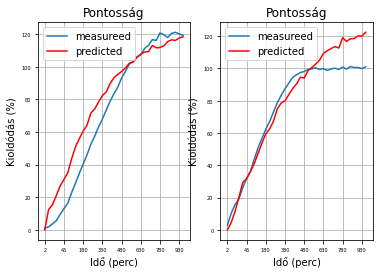

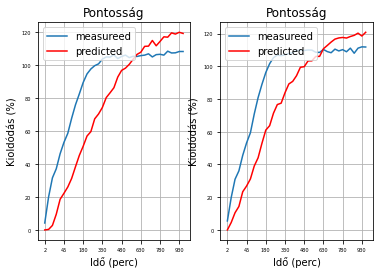

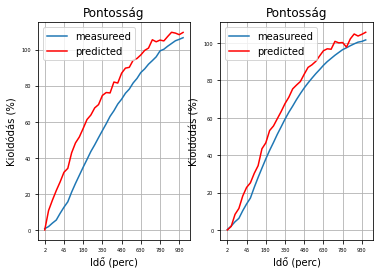

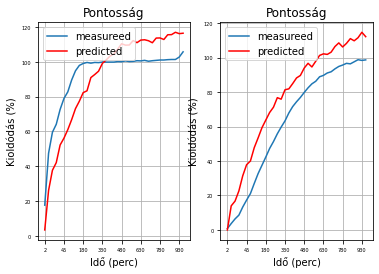

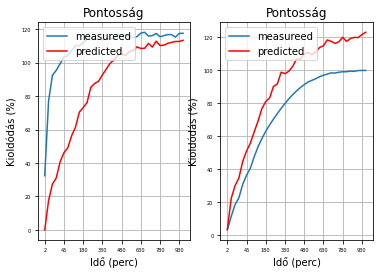

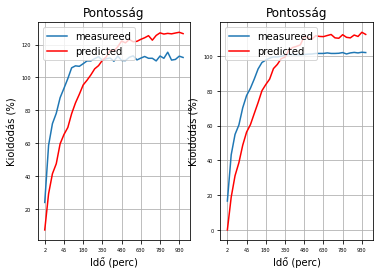

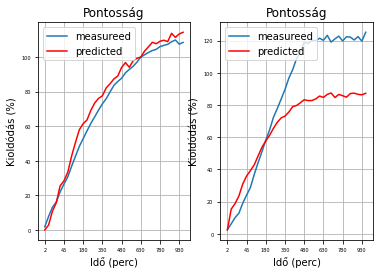

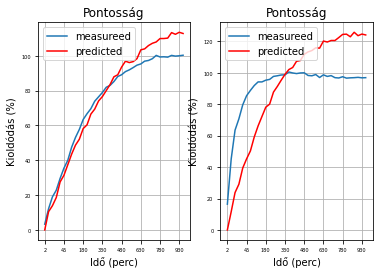

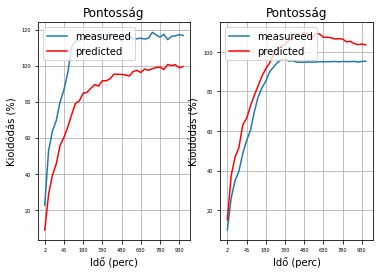

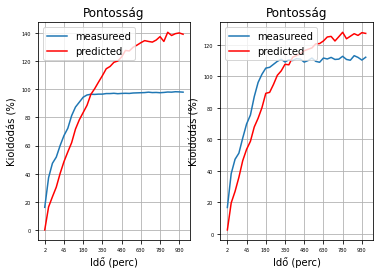

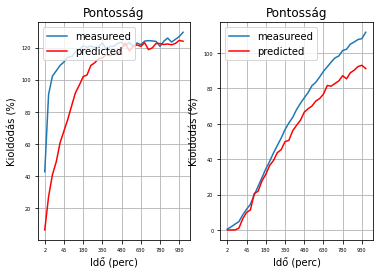

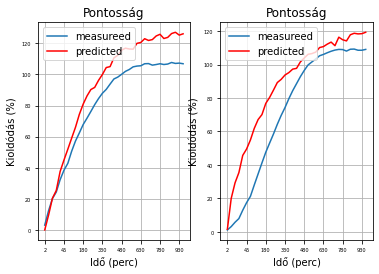

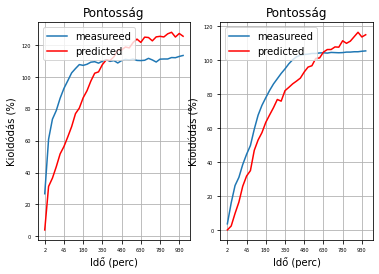

In [ ]:
if (model_name is None):
  model_name = 'base'
save_results_graph(time, y_test100, pre100, model_name)

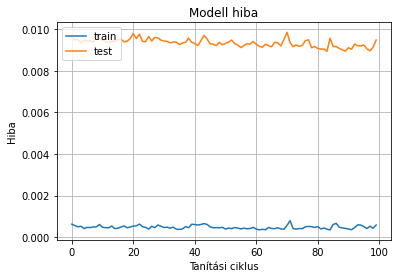

In [ ]:
if (model_name is None):
  model_name = 'base'
save_loss_graph(losses_history, model_name)

<div class="markdown-google-sans">

### <strong>Értékek</strong>
</div>


In [ ]:
if (model_name is None):
  model_name = 'base'
with open(DRIVE_PATH + 'saved_model/' + model_name + '/details.txt', 'w') as writefile:
    writefile.write("Train time: {0} s".format(sum(cb.logs)) + "\n")
    writefile.write("Train loss: {0}".format(model_loss_value(model, x_train, y_train)) + "\n")
    writefile.write("Test loss: {0}".format(model_loss_value(model, x_test, y_test)) + "\n")
    res_ = accuracy_for_all(y_test100, pre100)
    for k in res_.keys():
      writefile.write("{0}: {1}".format(k, res_[k]) + "\n")

History

In [ ]:
with open(DRIVE_PATH + 'saved_model/' + model_name + '/history', 'wb') as file_pi:
    pickle.dump(losses_history, file_pi)

print(file_pi)

<_io.BufferedWriter name='drive/MyDrive/Colab Notebooks/DissolutionFromRaman/saved_model/cnn2/history'>


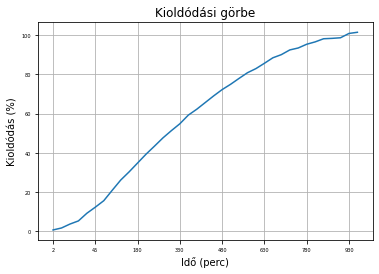

In [ ]:
save_dissolution_graph(time, y_test[4])